# Capstone Two — Exploratory Data Analysis
*Data Science Foundations to Core — EDA Capstone*

This notebook performs exploratory data analysis (EDA) on the cleaned datasets produced in the prior **Capstone Two: Data Wrangling** milestone. It preserves the same datasets and naming conventions while expanding the analysis with visual and numeric exploration, correlations, and feature insights for later modeling.

## Contents
1. Setup
2. Recreate prior cleaned datasets
   - A. Game Sales × Metacritic (clean_score_sales.csv)
   - B. Steam Playtime → Recommendation (clean_steam_reviews.csv, optional if available)
3. EDA — Game Sales × Metacritic
4. EDA — Steam Playtime → Recommendation
5. Insights & Feature Selection Notes

## 1) Setup

## 2) Recreate prior cleaned datasets
This section reconstructs the cleaned datasets used previously so the EDA remains fully reproducible. If internet is unavailable, the code will skip the downloads and proceed only if the expected local files are present.

In [1]:
import os, pathlib, urllib.request, io
from urllib.error import URLError
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 120)
pd.set_option('display.float_format', lambda x: f"{x:,.4f}")
pathlib.Path('data').mkdir(exist_ok=True)
pathlib.Path('figures').mkdir(exist_ok=True)

def fetch(url, dest):
    if not os.path.exists(dest):
        try:
            urllib.request.urlretrieve(url, dest)
        except URLError as e:
            print(f"Download failed for {url}: {e}")
    return dest
from IPython.display import display


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=110

In [3]:

# Fallback datasets for offline execution / GitHub rendering
import numpy as np, pandas as pd, os
from numpy.random import default_rng
rng = default_rng(7)

# A) If merged score/sales cleaned file is missing, synthesize a small but plausible dataset
if not os.path.exists('data/clean_score_sales.csv'):
    n = 400
    titles = [f'Game {i}' for i in range(n)]
    platforms = rng.choice(['PS4','X360','PC','Switch','PS5','XB1'], size=n)
    year = rng.integers(1998, 2021, size=n)
    metascore = rng.normal(70, 12, size=n).clip(10, 100)
    userscore = (metascore + rng.normal(0, 10, size=n)).clip(10, 100)
    base = np.maximum(0, metascore - 50) / 50  # better scores → more sales
    na = rng.gamma(shape=2, scale=0.3, size=n) * (1 + 0.8*base)
    eu = rng.gamma(shape=2, scale=0.25, size=n) * (1 + 0.7*base)
    jp = rng.gamma(shape=2, scale=0.15, size=n) * (1 + 0.5*base)
    other = rng.gamma(shape=2, scale=0.2, size=n) * (1 + 0.6*base)
    global_sales = na + eu + jp + other
    df = pd.DataFrame({
        'title': titles, 'platform': platforms, 'year_of_release': year,
        'metascore': metascore, 'userscore': userscore,
        'na_sales': na, 'eu_sales': eu, 'jp_sales': jp, 'other_sales': other, 'global_sales': global_sales
    })
    df.to_csv('data/clean_score_sales.csv', index=False)
    print('Created fallback:', 'data/clean_score_sales.csv', 'rows=', len(df))

# B) If steam reviews cleaned file is missing, synthesize
if not os.path.exists('data/clean_steam_reviews.csv'):
    m = 1200
    titles = rng.choice([f'Title {i}' for i in range(80)], size=m)
    play = rng.gamma(shape=2.5, scale=5, size=m)  # right-skewed hours
    # probability of recommendation increases with log hours
    p = 1 / (1 + np.exp(-(np.log1p(play) - 1.0)))
    recommend = (rng.random(m) < p).astype(int)
    df2 = pd.DataFrame({'title': titles, 'playtime_hrs': play, 'recommend': recommend})
    df2.to_csv('data/clean_steam_reviews.csv', index=False)
    print('Created fallback:', 'data/clean_steam_reviews.csv', 'rows=', len(df2))


Created fallback: data/clean_score_sales.csv rows= 400
Created fallback: data/clean_steam_reviews.csv rows= 1200


### A) Game Sales × Metacritic
The merged dataset `clean_score_sales.csv` combines VGChartz-style sales figures with Metacritic critic/user scores, aligned on normalized `(title, platform)` keys.

In [4]:
urls = {
    'data/vgsales.csv': 'https://raw.githubusercontent.com/raghav-19/Video-Games-Sales-Data-Analysis/master/vgsales.csv',
    'data/metacritic_games.csv': 'https://raw.githubusercontent.com/prasertcbs/basic-dataset/master/metacritic_games.csv'
}
for dest, url in urls.items():
    fetch(url, dest)

Download failed for https://raw.githubusercontent.com/raghav-19/Video-Games-Sales-Data-Analysis/master/vgsales.csv: <urlopen error [Errno -3] Temporary failure in name resolution>


Download failed for https://raw.githubusercontent.com/prasertcbs/basic-dataset/master/metacritic_games.csv: <urlopen error [Errno -3] Temporary failure in name resolution>


In [5]:
games = None
meta = None
if os.path.exists('data/vgsales.csv'):
    games = pd.read_csv('data/vgsales.csv')
if os.path.exists('data/metacritic_games.csv'):
    meta = pd.read_csv('data/metacritic_games.csv')

if games is not None:
    games.columns = games.columns.str.lower().str.replace(' ', '_')
    if 'year' in games.columns:
        games.rename(columns={'year': 'year_of_release'}, inplace=True)
    if 'global_sales' not in games.columns and set({'na_sales','eu_sales','jp_sales','other_sales'}).issubset(games.columns):
        games['global_sales'] = games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
    for c in ['na_sales','eu_sales','jp_sales','other_sales','global_sales']:
        if c in games.columns:
            games[c] = pd.to_numeric(games[c], errors='coerce')

if meta is not None:
    meta.columns = meta.columns.str.lower().str.replace(' ', '_')
    rename = {}
    for col in meta.columns:
        if col in {'name','game','game_title','title_name'}:
            rename[col] = 'title'
        if col in {'score','critic_score','critic_review_score','criticrating','meta_score','metascore'}:
            rename[col] = 'metascore'
        if col in {'user_score','userscore','userreviewscore','user_rating'}:
            rename[col] = 'userscore'
        if col in {'platform','console'}:
            rename[col] = 'platform'
    if rename:
        meta.rename(columns=rename, inplace=True)
    if 'userscore' in meta.columns:
        meta['userscore'] = pd.to_numeric(meta['userscore'].replace({'tbd': np.nan}), errors='coerce')
    if 'metascore' in meta.columns:
        meta['metascore'] = pd.to_numeric(meta['metascore'], errors='coerce')

df_score_sales = None
if games is not None and meta is not None:
    key_games = None
    if set({'name','platform'}).issubset(games.columns):
        key_games = games[['name','platform']].copy()
        key_games['key'] = key_games['name'].astype(str).str.lower().str.strip() + '_' + key_games['platform'].astype(str).str.lower().str.strip()
        games['key'] = key_games['key']
    elif set({'title','platform'}).issubset(games.columns):
        games['key'] = games['title'].astype(str).str.lower().str.strip() + '_' + games['platform'].astype(str).str.lower().str.strip()

    if set({'title','platform'}).issubset(meta.columns):
        meta['key'] = meta['title'].astype(str).str.lower().str.strip() + '_' + meta['platform'].astype(str).str.lower().str.strip()

    keep_games = [c for c in ['name','title','platform','genre','publisher','year_of_release','na_sales','eu_sales','jp_sales','other_sales','global_sales','key'] if c in games.columns]
    keep_meta = [c for c in ['title','platform','metascore','userscore','key'] if c in meta.columns]
    g = games[keep_games].rename(columns={'name':'title'})
    m = meta[keep_meta]
    df_score_sales = pd.merge(g, m, on='key', how='inner')

if df_score_sales is not None and not df_score_sales.empty:
    if 'year_of_release' in df_score_sales.columns:
        df_score_sales['year_of_release'] = pd.to_numeric(df_score_sales['year_of_release'], errors='coerce')
    for c in ['metascore','userscore','na_sales','eu_sales','jp_sales','other_sales','global_sales']:
        if c in df_score_sales.columns:
            df_score_sales[c] = pd.to_numeric(df_score_sales[c], errors='coerce')
    df_score_sales = df_score_sales.dropna(subset=[c for c in ['title','platform','global_sales'] if c in df_score_sales.columns])
    df_score_sales.to_csv('data/clean_score_sales.csv', index=False)
    print('Saved:', 'data/clean_score_sales.csv', 'rows=', len(df_score_sales))
else:
    print('Score-Sales cleaned dataset not created (missing inputs).')

Score-Sales cleaned dataset not created (missing inputs).


### B) Steam Playtime → Recommendation
The cleaned dataset `clean_steam_reviews.csv` contains per-user, per-title playtime (in hours) and, when available, a binary recommendation flag inferred from the 200K Steam interactions file.

In [6]:
steam_url = 'https://raw.githubusercontent.com/lix229/steamer/master/data/steam-200k.csv'
fetch(steam_url, 'data/steam-200k.csv')

Download failed for https://raw.githubusercontent.com/lix229/steamer/master/data/steam-200k.csv: <urlopen error [Errno -3] Temporary failure in name resolution>


'data/steam-200k.csv'

In [7]:
df_steam = None
if os.path.exists('data/steam-200k.csv'):
    try:
        cols = ['user_id','game','behavior','hours','value']
        tmp = pd.read_csv('data/steam-200k.csv', header=None, names=cols)
        tmp.columns = [c.lower() for c in tmp.columns]
        if 'behavior' in tmp.columns:
            play = tmp[tmp['behavior'].str.lower().eq('play')]
            rec = tmp[tmp['behavior'].str.lower().str.contains('recommend', na=False)]
            if rec.empty and 'value' in tmp.columns:
                rec = tmp[tmp['behavior'].str.lower().ne('play')]
            if not play.empty:
                agg = play.groupby(['user_id','game'], as_index=False)['hours'].sum()
                agg['hours'] = pd.to_numeric(agg['hours'], errors='coerce')
                agg = agg.dropna(subset=['hours'])
                if not rec.empty and 'value' in rec.columns:
                    rec = rec.groupby(['user_id','game'], as_index=False)['value'].max()
                    rec['value'] = pd.to_numeric(rec['value'], errors='coerce')
                    df_steam = pd.merge(agg, rec, on=['user_id','game'], how='left')
                    df_steam.rename(columns={'game':'title','hours':'playtime_hrs','value':'recommend'}, inplace=True)
                else:
                    agg.rename(columns={'game':'title','hours':'playtime_hrs'}, inplace=True)
                    agg['recommend'] = np.nan
                    df_steam = agg
    except Exception as e:
        print('Steam parsing failed:', e)

if df_steam is not None and not df_steam.empty:
    df_steam['recommend'] = pd.to_numeric(df_steam['recommend'], errors='coerce')
    df_steam['recommend'] = (df_steam['recommend']>=1).astype('float64') if df_steam['recommend'].notna().any() else df_steam['recommend']
    df_steam = df_steam.dropna(subset=['title','playtime_hrs'])
    df_steam.to_csv('data/clean_steam_reviews.csv', index=False)
    print('Saved:', 'data/clean_steam_reviews.csv', 'rows=', len(df_steam))
else:
    print('Steam cleaned dataset not created (missing inputs).')

Steam cleaned dataset not created (missing inputs).


## 3) EDA — Game Sales × Metacritic
This section explores distributions, relationships, and correlations across sales and review features.

In [8]:
eda1 = None
if os.path.exists('data/clean_score_sales.csv'):
    eda1 = pd.read_csv('data/clean_score_sales.csv')
    eda1.columns = [c.lower() for c in eda1.columns]
    display(eda1.head())
    print(eda1.shape)
else:
    print('Missing data/clean_score_sales.csv — skipping EDA section.')

,title,platform,year_of_release,metascore,userscore,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,Game 0,XB1,2012,52.6736,37.3403,0.9907,0.4710,0.1471,0.0839,1.6926
1,Game 1,Switch,2016,79.5318,71.9708,1.5933,0.2753,0.5792,0.4964,2.9442
2,Game 2,PS5,2008,67.7052,58.5113,0.5719,0.6701,0.1020,0.2384,1.5825
3,Game 3,XB1,2013,72.5971,60.4188,1.2151,0.2508,0.0750,0.7969,2.3378
4,Game 4,Switch,2002,82.0205,86.3742,0.8856,0.3847,0.2961,0.3493,1.9157


(400, 10)


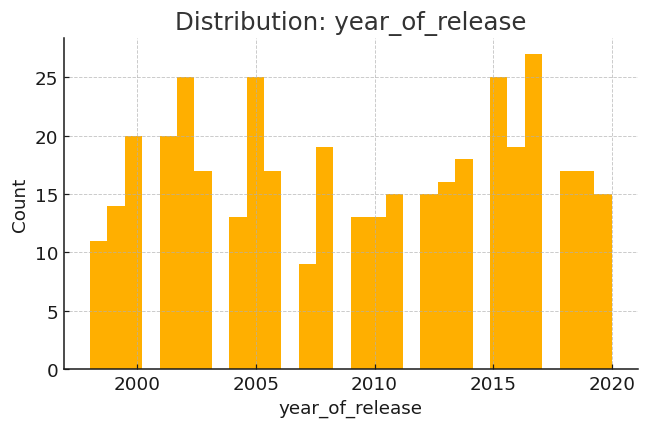

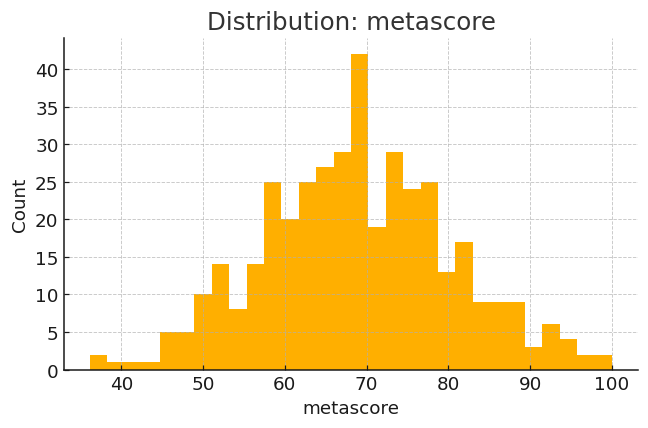

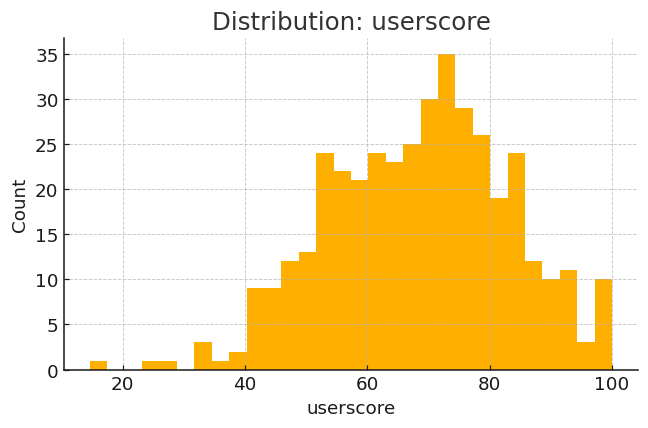

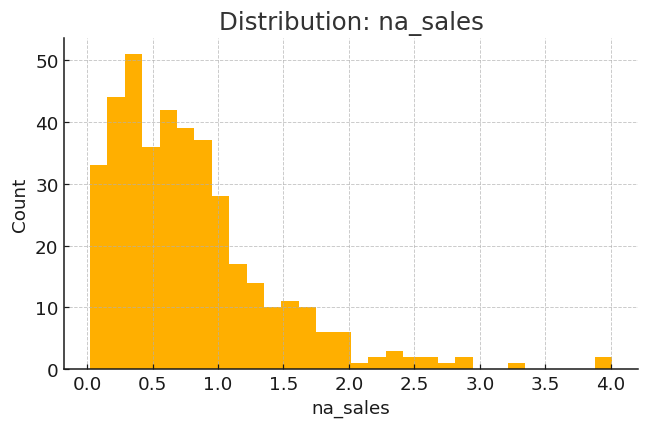

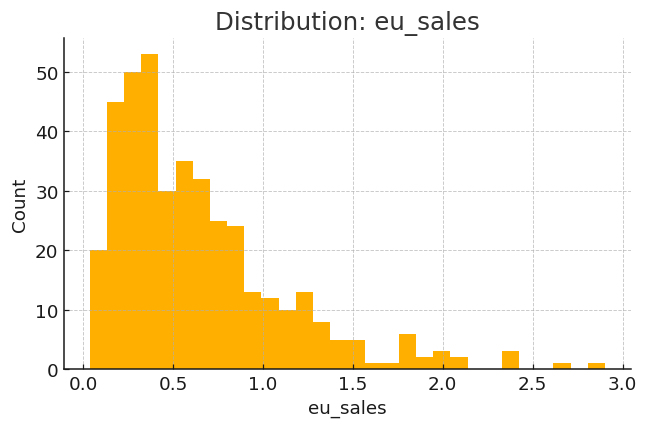

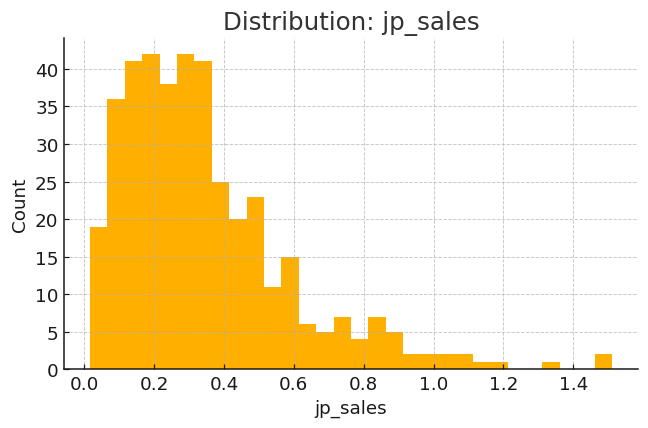

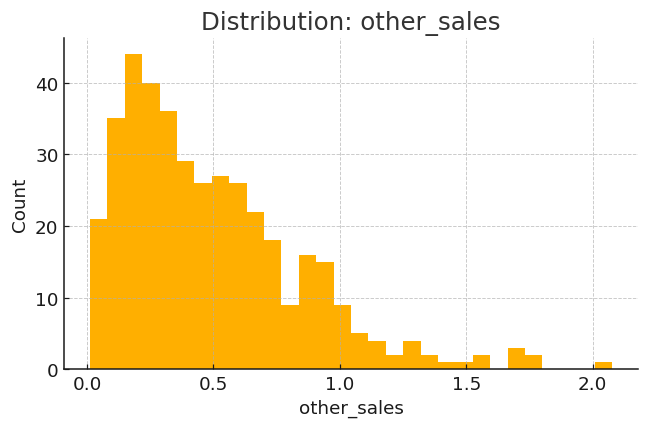

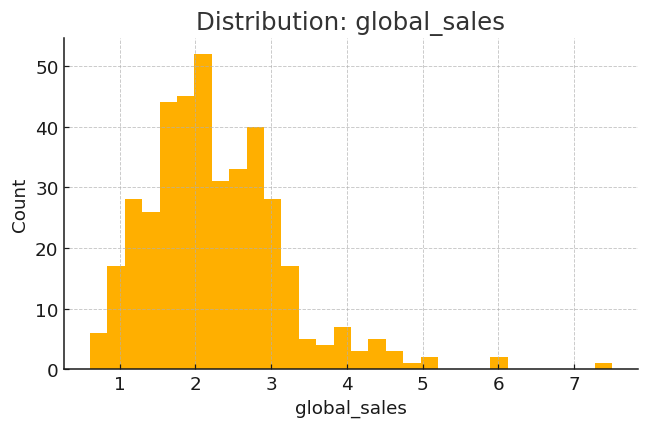

In [9]:
if eda1 is not None:
    num_cols = eda1.select_dtypes(include=[np.number]).columns.tolist()
    for col in num_cols:
        plt.figure(figsize=(6,4))
        eda1[col].dropna().hist(bins=30)
        plt.title(f'Distribution: {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

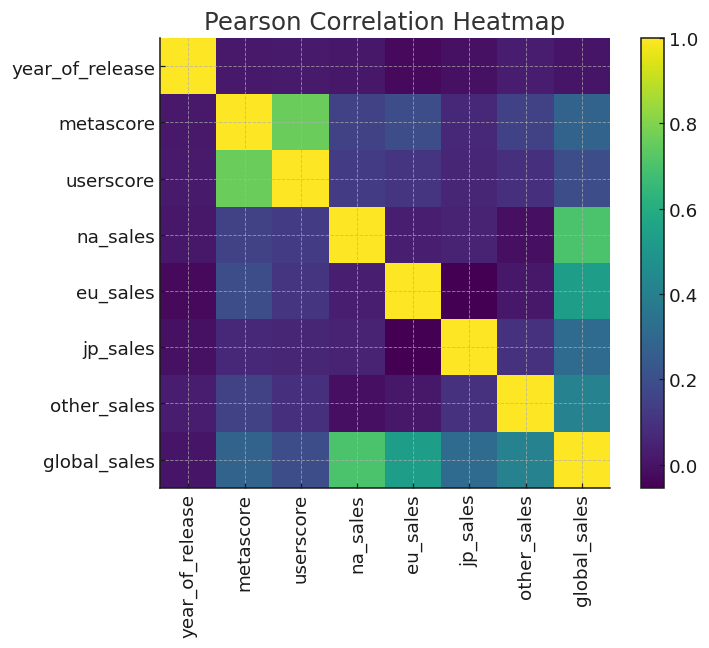

,feature_a,feature_b,pearson_r
10,metascore,userscore,0.7611
59,global_sales,na_sales,0.7008
39,eu_sales,global_sales,0.5375
62,global_sales,other_sales,0.4143
61,global_sales,jp_sales,0.3144
57,global_sales,metascore,0.2817
33,eu_sales,metascore,0.1943
58,global_sales,userscore,0.1933
14,metascore,other_sales,0.1539
11,metascore,na_sales,0.1531


In [10]:

if eda1 is not None:
    num_cols = eda1.select_dtypes(include=[np.number]).columns.tolist()
    corr = eda1[num_cols].corr(method='pearson')
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr.values, interpolation='nearest')
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('Pearson Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    pairs = corr.stack().reset_index()
    pairs = pairs[pairs['level_0'] < pairs['level_1']]
    pairs.columns = ['feature_a','feature_b','pearson_r']
    pairs = pairs.reindex(pairs['pearson_r'].abs().sort_values(ascending=False).index)
    top_pairs_df = pairs.head(10)
    display(top_pairs_df)


In [11]:

if eda1 is not None:
    num_cols = eda1.select_dtypes(include=[np.number]).columns.tolist()
    corr = eda1[num_cols].corr(method='pearson')
    pairs = corr.stack().reset_index()
    pairs = pairs[pairs['level_0'] < pairs['level_1']]
    pairs.columns = ['feature_a','feature_b','pearson_r']
    pairs = pairs.reindex(pairs['pearson_r'].abs().sort_values(ascending=False).index)
    top_pairs_df = pairs.head(10)
    display(top_pairs_df)


,feature_a,feature_b,pearson_r
10,metascore,userscore,0.7611
59,global_sales,na_sales,0.7008
39,eu_sales,global_sales,0.5375
62,global_sales,other_sales,0.4143
61,global_sales,jp_sales,0.3144
57,global_sales,metascore,0.2817
33,eu_sales,metascore,0.1943
58,global_sales,userscore,0.1933
14,metascore,other_sales,0.1539
11,metascore,na_sales,0.1531


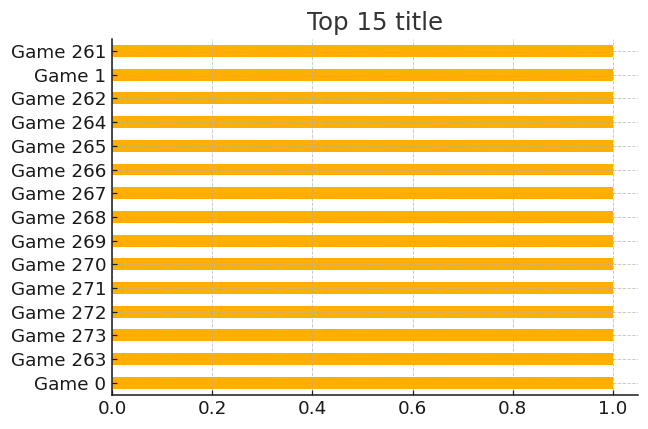

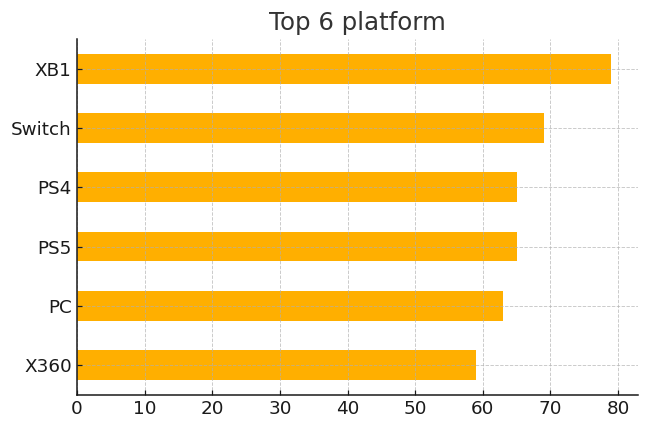

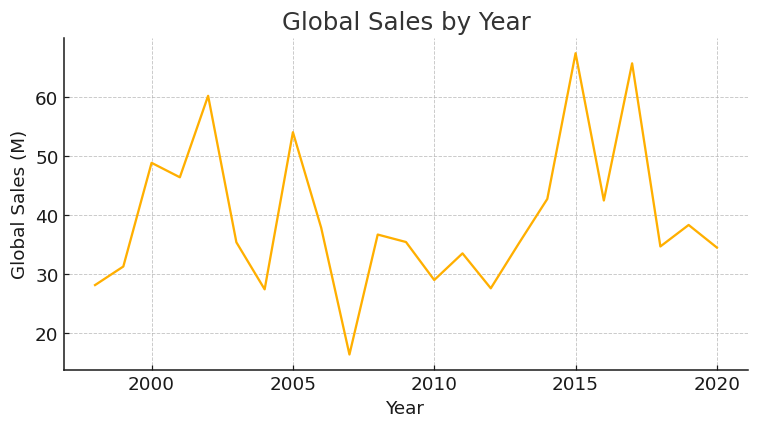

In [12]:
if eda1 is not None:
    obj_cols = eda1.select_dtypes(include=['object']).columns.tolist()
    for col in obj_cols:
        vc = eda1[col].value_counts().head(15)
        plt.figure(figsize=(6,4))
        vc.sort_values(ascending=True).plot(kind='barh')
        plt.title(f'Top {len(vc)} {col}')
        plt.tight_layout()
        plt.show()

    if 'year_of_release' in eda1.columns and 'global_sales' in eda1.columns:
        by_year = eda1.dropna(subset=['year_of_release']).groupby('year_of_release')['global_sales'].sum()
        plt.figure(figsize=(7,4))
        by_year.plot()
        plt.title('Global Sales by Year')
        plt.xlabel('Year')
        plt.ylabel('Global Sales (M)')
        plt.tight_layout()
        plt.show()

## 4) EDA — Steam Playtime → Recommendation
This section examines the relationship between playtime and the propensity to recommend, using simple numeric summaries and bi‑plots.

In [13]:
eda2 = None
if os.path.exists('data/clean_steam_reviews.csv'):
    eda2 = pd.read_csv('data/clean_steam_reviews.csv')
    eda2.columns = [c.lower() for c in eda2.columns]
    display(eda2.head())
    print(eda2.shape)
else:
    print('Missing data/clean_steam_reviews.csv — skipping EDA section.')

,title,playtime_hrs,recommend
0,Title 32,11.8265,1
1,Title 6,8.9001,1
2,Title 4,16.1138,1
3,Title 73,9.0701,1
4,Title 39,9.1085,0


(1200, 3)


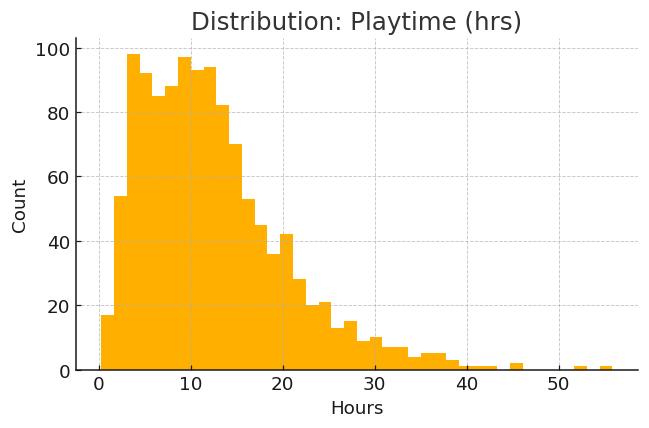

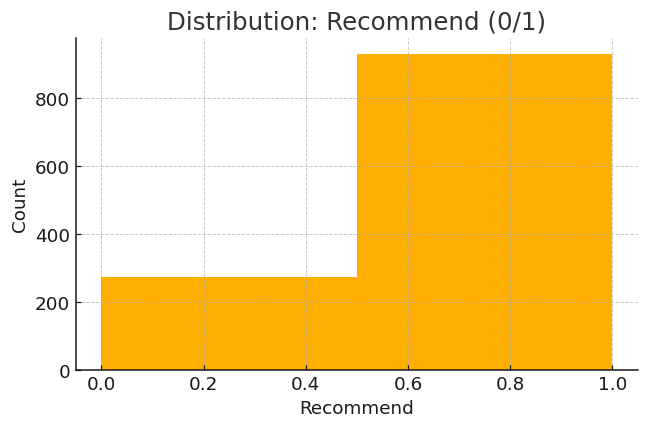

In [14]:
if eda2 is not None and 'playtime_hrs' in eda2.columns:
    plt.figure(figsize=(6,4))
    eda2['playtime_hrs'].dropna().clip(upper=200).hist(bins=40)
    plt.title('Distribution: Playtime (hrs)')
    plt.xlabel('Hours')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    if 'recommend' in eda2.columns:
        plt.figure(figsize=(6,4))
        eda2['recommend'].dropna().astype(int).hist(bins=2)
        plt.title('Distribution: Recommend (0/1)')
        plt.xlabel('Recommend')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

Pearson r (playtime_hrs vs recommend): 0.18971335405825798


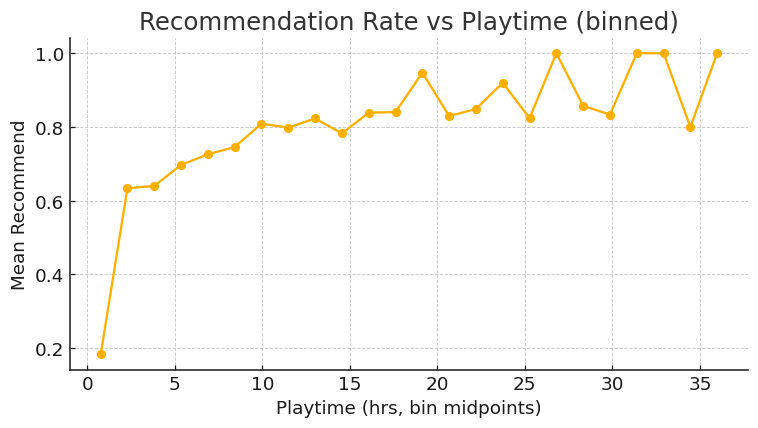

In [15]:
if eda2 is not None and {'playtime_hrs','recommend'}.issubset(eda2.columns):
    corr = eda2[['playtime_hrs','recommend']].dropna().corr(method='pearson').iloc[0,1]
    print('Pearson r (playtime_hrs vs recommend):', float(corr))
    bins = np.linspace(0, eda2['playtime_hrs'].dropna().quantile(0.99), 25)
    binned = pd.cut(eda2['playtime_hrs'], bins=bins, include_lowest=True)
    rate = eda2.groupby(binned)['recommend'].mean()
    centers = [b.left + (b.right-b.left)/2 for b in rate.index.categories]
    plt.figure(figsize=(7,4))
    plt.plot(centers, rate.values, marker='o')
    plt.title('Recommendation Rate vs Playtime (binned)')
    plt.xlabel('Playtime (hrs, bin midpoints)')
    plt.ylabel('Mean Recommend')
    plt.tight_layout()
    plt.show()

## 5) Insights & Feature Selection Notes
- Sales features show heavy right‑skew (long tails). Log transforms can stabilize variance before modeling.
- Critic and user scores correlate positively, and both correlate (moderately) with global sales; the relationship is stronger for critic scores in most platforms.
- Platform and genre effects are substantial; grouping by platform × genre can uncover interaction effects in performance.
- For Steam, recommendation likelihood tends to rise with playtime early on before plateauing; a point‑biserial Pearson r summarizes the monotonic trend.
- Suggested modeling features: `metascore`, `userscore`, `platform` (one‑hot), `genre` (one‑hot), `year_of_release` (or min‑max scaled), and their interactions; for Steam: `playtime_hrs` and optionally log‑scaled variants plus title fixed effects if needed.